# Imports necessários

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Carga do modelo pré-treinado

In [2]:
model_lstm = tf.keras.models.load_model('receitas_2013_2022')

# Carga nos dados

## Receitas

In [3]:
dados_receitas = pd.read_csv('data/dados_receitas.csv', sep=';')
dados_receitas.head()

,COD_RECEITA,DATA,COD_CONTRIBUINTE,VALOR_ARRECADADO,FONTE_DADOS
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68,prefeitura municipal
1,1722010101,2013-01-04,886cd0eabf5a18,8081.80,prefeitura municipal
2,1722010101,2013-01-07,886cd0eabf5a18,4231.39,prefeitura municipal
3,1722010101,2013-01-08,886cd0eabf5a18,10536.53,prefeitura municipal
4,1722010101,2013-01-15,886cd0eabf5a18,103118.27,prefeitura municipal


## Despesas

In [4]:
dados_despesas = pd.read_csv('data/dados_despesas.csv', sep=';')
dados_despesas.head()

,DATA_FATO,FONTE_RECURSO,ORGAO_INTERNO,ORGAO_VINCULADO,ELEMENTO,SUBELEMENTO,FUNCAO,SUBFUNCAO,NATUREZA,VALOR_FIXADO,VALOR_EMPENHADO,VALOR_LIQUIDADO,VALOR_PAGO,SALDO,CODIGO
0,2013-12-31,recursos ordinarios,secretaria municipal de infra estrutura,prefeitura municipal,39,2044,4,122,3,2911694.0,5120.0,5120.0,0.0,5120.0,80e7979ff78e14
1,2013-12-31,recursos ordinarios,secretaria municipal de educacao,prefeitura municipal,36,2029,13,392,3,107000.0,6950.0,6950.0,0.0,6950.0,4be681d5c1e352
2,2013-12-31,recursos ordinarios,secretaria municipal de educacao,prefeitura municipal,36,2029,13,392,3,107000.0,800.0,800.0,0.0,800.0,8ff22c743e712e
3,2013-12-31,recursos ordinarios,secretaria municipal de educacao,prefeitura municipal,36,2029,13,392,3,107000.0,400.0,400.0,0.0,400.0,1db102414906f0
4,2013-12-31,recursos ordinarios,secretaria municipal de educacao,prefeitura municipal,36,2029,13,392,3,107000.0,600.0,600.0,0.0,600.0,5125ea1b50db6d


# Data engineering

## Receitas

In [5]:
# Converter a coluna 'DATA' para o tipo datetime
dados_receitas['DATA'] = pd.to_datetime(dados_receitas['DATA'])

# Extrair o ano, mês e dia da coluna 'DATA' como novas features
dados_receitas['ANO'] = dados_receitas['DATA'].dt.year

Q1: 51.23
Q3: 1579.25
IQR: 1528.02
Limite inferior: -2240.7999999999997
Limite superior: 3871.2799999999997
Quantidade de registros sem outliers: 83736


<Axes: title={'center': 'VALOR_ARRECADADO'}, xlabel='[ANO]'>

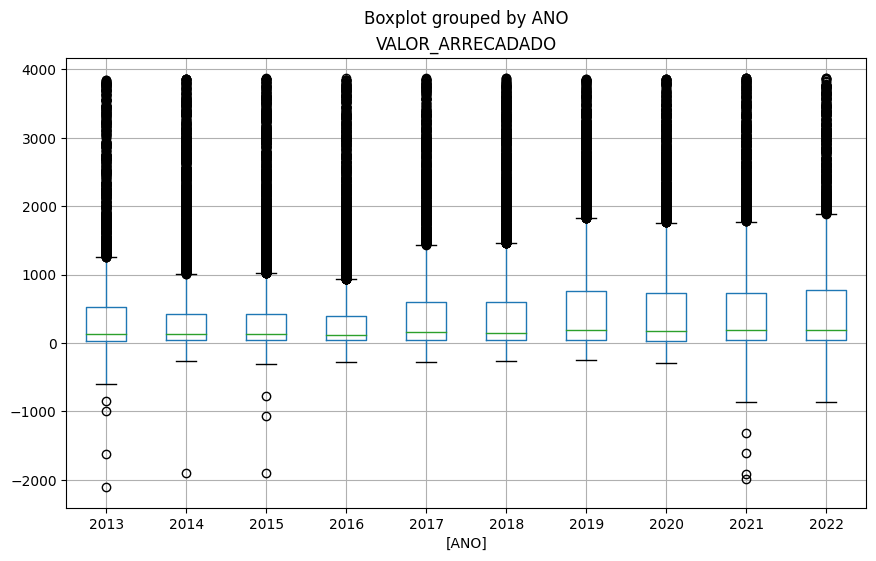

In [6]:
# aplicação de IQR - interquartile range
Q1 = dados_receitas['VALOR_ARRECADADO'].quantile(0.25)
Q3 = dados_receitas['VALOR_ARRECADADO'].quantile(0.75)
IQR = Q3 - Q1
print(f'Q1: {Q1}')
print(f'Q3: {Q3}')
print(f'IQR: {IQR}')

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
print(f'Limite inferior: {limite_inferior}')
print(f'Limite superior: {limite_superior}')

df_sem_outliers = dados_receitas[(dados_receitas['VALOR_ARRECADADO'] >= limite_inferior) & (dados_receitas['VALOR_ARRECADADO'] <= limite_superior)]
df_sem_outliers = df_sem_outliers[['ANO', 'VALOR_ARRECADADO']]
print(f'Quantidade de registros sem outliers: {df_sem_outliers.shape[0]}')
df_sem_outliers.boxplot(by='ANO', figsize=(10, 6))

In [7]:
df_sem_outliers = dados_receitas[(dados_receitas['VALOR_ARRECADADO'] >= limite_inferior) & (dados_receitas['VALOR_ARRECADADO'] <= limite_superior)]

In [8]:
df_receitas = df_sem_outliers.copy()

In [9]:
df_receitas.drop(columns=['COD_RECEITA', 'COD_CONTRIBUINTE', 'FONTE_DADOS', 'ANO'], inplace=True)

In [10]:
df_receitas['SMA(12)'] = df_receitas['VALOR_ARRECADADO'].rolling(window=12).mean()
df_receitas['SMA(6)'] = df_receitas['VALOR_ARRECADADO'].rolling(window=6).mean()
df_receitas['SMA(3)'] = df_receitas['VALOR_ARRECADADO'].rolling(window=3).mean()
df_receitas['SMA(2)'] = df_receitas['VALOR_ARRECADADO'].rolling(window=2).mean()
df_receitas.head()

,DATA,VALOR_ARRECADADO,SMA(12),SMA(6),SMA(3),SMA(2)
8,2013-01-04,-1616.36,NaN,NaN,NaN,NaN
10,2013-01-08,-2107.30,NaN,NaN,NaN,-1861.830
18,2013-01-31,2075.64,NaN,NaN,-549.340000,-15.830
19,2013-01-03,111.96,NaN,NaN,26.766667,1093.800
20,2013-01-07,57.17,NaN,NaN,748.256667,84.565


In [11]:
df_receitas['lag(12)'] = df_receitas['VALOR_ARRECADADO'].shift(12)
df_receitas['lag(6)'] = df_receitas['VALOR_ARRECADADO'].shift(6)
df_receitas['lag(4)'] = df_receitas['VALOR_ARRECADADO'].shift(4)
df_receitas['lag(3)'] = df_receitas['VALOR_ARRECADADO'].shift(3)
df_receitas['lag(2)'] = df_receitas['VALOR_ARRECADADO'].shift(2)
df_receitas['lag(1)'] = df_receitas['VALOR_ARRECADADO'].shift(1)
df_receitas.head()

,DATA,VALOR_ARRECADADO,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
8,2013-01-04,-1616.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2013-01-08,-2107.30,NaN,NaN,NaN,-1861.830,NaN,NaN,NaN,NaN,NaN,-1616.36
18,2013-01-31,2075.64,NaN,NaN,-549.340000,-15.830,NaN,NaN,NaN,NaN,-1616.36,-2107.30
19,2013-01-03,111.96,NaN,NaN,26.766667,1093.800,NaN,NaN,NaN,-1616.36,-2107.30,2075.64
20,2013-01-07,57.17,NaN,NaN,748.256667,84.565,NaN,NaN,-1616.36,-2107.30,2075.64,111.96


In [12]:
df_receitas.dropna(inplace=True)
df_receitas.head()

,DATA,VALOR_ARRECADADO,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
29,2013-01-18,1034.25,512.357500,983.083333,1510.706667,1189.280,-1616.36,107.32,1224.76,136.62,2153.56,1344.31
30,2013-01-21,1548.27,816.988333,1240.295000,1308.943333,1291.260,-2107.30,5.00,136.62,2153.56,1344.31,1034.25
31,2013-01-22,3212.34,911.713333,1571.558333,1931.620000,2380.305,2075.64,1224.76,2153.56,1344.31,1034.25,1548.27
33,2013-01-25,1366.81,1016.284167,1776.590000,2042.473333,2289.575,111.96,136.62,1344.31,1034.25,1548.27,3212.34
34,2013-01-28,5.05,1011.940833,1418.505000,1528.066667,685.930,57.17,2153.56,1034.25,1548.27,3212.34,1366.81


In [13]:
df_receitas['DATA'] = pd.to_datetime(df_receitas['DATA'])
df_receitas['DATA'] = df_receitas['DATA'].map(dt.datetime.toordinal)

# Aplicação do modelo a base de dados

In [14]:
def prediction(model):
    y_pred = model.predict(X)
    y_pred = scaler_y.inverse_transform(y_pred)
    return y_pred

In [15]:
def plot_future(prediction, y, tipo):
    plt.figure(figsize=(10,6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y), label='Dados reais')
    plt.plot(np.arange(range_future), np.array(prediction),label='Previsão')
    plt.legend(loc='upper left')
    plt.xlabel('Mês')
    plt.ylabel('Valor Arrecadado')
    plt.title('Predição de Receitas - LSTM')
    plt.savefig(f'fig_pred_{tipo}.png')
    plt.show()

In [16]:
scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

## Receitas

In [17]:
X = df_receitas.drop(['VALOR_ARRECADADO'], axis=1)
y = df_receitas.loc[:, ['VALOR_ARRECADADO']]

In [18]:
input_scaler = scaler_x.fit(X)
output_scaler = scaler_y.fit(y)

In [19]:
y_norm = output_scaler.transform(y)
X_norm = input_scaler.transform(X)

In [20]:
X = X_norm.reshape((X_norm.shape[0], 1, X_norm.shape[1]))
y = y_norm.reshape((y_norm.shape[0], 1))

In [21]:
y = scaler_y.inverse_transform(y)

In [22]:
prediction_lstm = prediction(model_lstm)

2617/2617 [==============================] - 17s 6ms/step


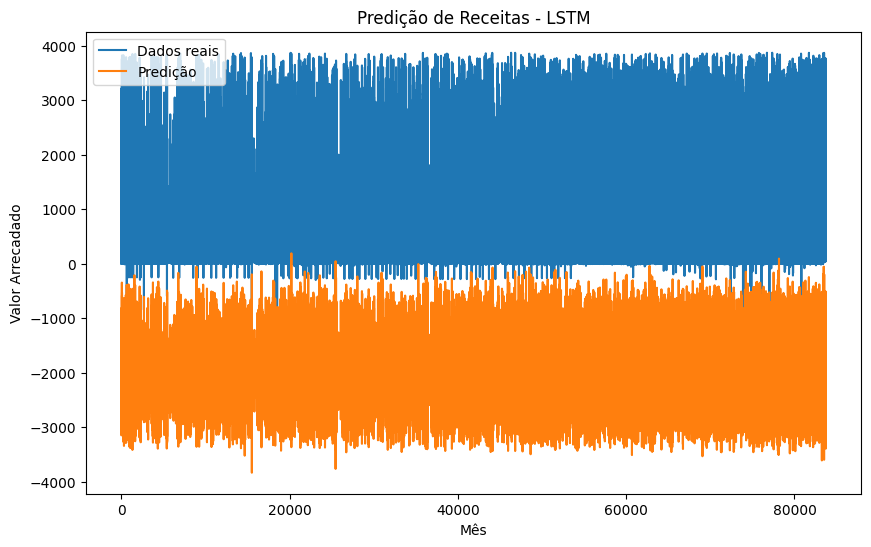

In [23]:
plot_future(prediction_lstm, y, 'receitas_2013_2022')

Cálculo do erro médio percentual:

In [24]:
real = y.flatten()
previsto = prediction_lstm.flatten()

In [25]:
tabela = pd.DataFrame([real, previsto]).T
tabela = tabela.rename(columns={0: 'Real', 1: 'Previsto'})
tabela['Diferenca'] = 1 - (tabela['Real'] / tabela['Previsto'])
media_tabela = tabela['Diferenca'].mean()
print(f'Erro médio percentual: {media_tabela:.2f}%')

Erro médio percentual: 1.38%
